# Formatting

In [ ]:
# -- Install as needed --

# !pip install librosa soundfile
# !pip install sentence-transformers
# !pip install google-cloud-storage
# !pip install openai
# !pip install tqdm

In [ ]:
import os
import json
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import librosa
#from openai import OpenAI
from google.cloud import storage
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import tempfile
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import necessary libraries for authentication
from google.colab import auth
from google.cloud import storage
import os

# Authenticate with Google Cloud
print("🔐 Authenticating with Google Cloud...")
auth.authenticate_user()

# Set up your specific Google Cloud projectr project ID from the screenshot
project_id = "bayes-beats"

🔐 Authenticating with Google Cloud...


In [ ]:
#from google.cloud import storage
#from tqdm import tqdm


# --- Config ---
BUCKET_NAME = "uchicago-bayesian-bayes-beats"
BASE_FOLDER = "jamendo_by_genre"
CLIENT_ID = "a62fe3ee"
AUDIO_FORMAT = "mp32"
TRACKS_PER_GENRE = 20
SAMPLE_RATE = 22050
DURATION = 30
N_MELS = 128
HOP_LENGTH = 512


# --- Initialize clients and models ---
client = storage.Client()
bucket = client.bucket(BUCKET_NAME)

try:
    # Try to get project ID from environment
    project_id = os.environ.get('GOOGLE_CLOUD_PROJECT')
    if project_id:
        client = storage.Client(project=project_id)
    else:
        client = storage.Client()  # Will use default project

    bucket = client.bucket(BUCKET_NAME)
    # Test bucket access
    bucket.reload()
    print(f"✅ Successfully connected to bucket: {BUCKET_NAME}")

except Exception as e:
    print(f"❌ Error connecting to GCS: {e}")
    print("Make sure you've run the setup script and authenticated properly")
    raise


sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

❌ Error connecting to GCS: 403 GET https://storage.googleapis.com/storage/v1/b/uchicago-bayesian-bayes-beats?projection=noAcl&prettyPrint=false: drosenthal@uchicago.edu does not have storage.buckets.get access to the Google Cloud Storage bucket. Permission 'storage.buckets.get' denied on resource (or it may not exist).
Make sure you've run the setup script and authenticated properly


Forbidden: 403 GET https://storage.googleapis.com/storage/v1/b/uchicago-bayesian-bayes-beats?projection=noAcl&prettyPrint=false: drosenthal@uchicago.edu does not have storage.buckets.get access to the Google Cloud Storage bucket. Permission 'storage.buckets.get' denied on resource (or it may not exist).

In [ ]:
# OpenAI key
from openai import OpenAI
client = OpenAI(api_key=OPENAI_API_KEY)

In [ ]:
class AudioFeatureExtractor:
    """Extract comprehensive audio features for vibe analysis"""

    def __init__(self, sr=SAMPLE_RATE, duration=DURATION):
        self.sr = sr
        self.duration = duration

    def extract_features(self, audio_path):
        """Extract audio features including tempo, spectral features, and rhythm"""
        try:
            # Load audio
            y, sr = librosa.load(audio_path, sr=self.sr, duration=self.duration)

            # Basic features
            tempo, beats = librosa.beat.beat_track(y=y, sr=sr)

            # Spectral features
            spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
            spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]

            # MFCC features
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

            # Chroma features (harmonic content)
            chroma = librosa.feature.chroma_stft(y=y, sr=sr)

            # Zero crossing rate (indicates percussive vs harmonic content)
            zcr = librosa.feature.zero_crossing_rate(y)[0]

            # RMS Energy
            rms = librosa.feature.rms(y=y)[0]

            # Mel spectrogram for deep learning
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

            features = {
                'tempo': float(tempo),
                'spectral_centroid_mean': float(np.mean(spectral_centroids)),
                'spectral_centroid_std': float(np.std(spectral_centroids)),
                'spectral_rolloff_mean': float(np.mean(spectral_rolloff)),
                'spectral_bandwidth_mean': float(np.mean(spectral_bandwidth)),
                'mfcc_mean': np.mean(mfccs, axis=1).tolist(),
                'chroma_mean': np.mean(chroma, axis=1).tolist(),
                'zcr_mean': float(np.mean(zcr)),
                'rms_mean': float(np.mean(rms)),
                'rms_std': float(np.std(rms)),
                'mel_spectrogram': mel_spec_db.tolist()  # For DCAE input
            }

            return features

        except Exception as e:
            print(f"Error extracting features: {e}")
            return None

class SimpleDCAE(nn.Module):
    """Simplified Deep Convolutional Autoencoder for audio latent representation"""

    def __init__(self, input_shape=(N_MELS, 1292)):  # Approximate mel-spec shape for 30s audio
        super(SimpleDCAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, 128)  # Latent dimension
        )

        # Decoder (for training, not used in final pipeline)
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decoder(encoded)
        return decoded

def generate_vibe_description(features, genre, filename):
    """Generate vibe description using OpenAI GPT"""

    # Create a descriptive prompt based on audio features
    tempo_desc = "fast-paced" if features['tempo'] > 120 else "moderate" if features['tempo'] > 80 else "slow"
    energy_desc = "high-energy" if features['rms_mean'] > 0.1 else "mellow"
    brightness_desc = "bright" if features['spectral_centroid_mean'] > 2000 else "warm"

    system_prompt = """You are a music curator who creates evocative, atmospheric descriptions of songs based on their audio characteristics.
Create a short, vivid description that captures the 'vibe' or mood the song would create.
Focus on emotions, settings, activities, or scenarios the music evokes.
Keep it under 20 words and make it atmospheric and engaging."""

    user_prompt = f"""Genre: {genre}
Tempo: {features['tempo']:.1f} BPM ({tempo_desc})
Energy: {energy_desc}
Tonal quality: {brightness_desc}
Zero-crossing rate: {features['zcr_mean']:.4f}

Create a vibe description for this {genre} track."""

    try:
        resp = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user",   "content": user_prompt}
            ],
            max_tokens=50,
            temperature=0.8
        )
        return resp.choices[0].message.content.strip()

    except Exception as e:
        print(f"Error generating description: {e}")
        return f"{energy_desc} {genre} vibes with {tempo_desc} rhythm"


def get_genre_folders(bucket, base_folder):
    """
    Return a list of the immediate sub-directories under `base_folder/` in GCS.
    e.g. ['ambient','blues','classical',…]
    """
    iterator = bucket.list_blobs(prefix=f"{base_folder}/", delimiter="/")
    prefixes = set()

    # You have to iterate over pages to get the .prefixes attribute
    for page in iterator.pages:
        prefixes.update(page.prefixes)

    # each prefix looks like "jamendo_by_genre/ambient/"
    genres = [p.rstrip("/").split("/")[-1] for p in prefixes]
    return genres


def sample_songs_from_genre(genre, n_samples=TRACKS_PER_GENRE):
    """Randomly sample n songs from a genre folder"""
    blobs = list(bucket.list_blobs(prefix=f"{BASE_FOLDER}/{genre}/"))
    mp3_blobs = [blob for blob in blobs if blob.name.endswith('.mp3')]

    if len(mp3_blobs) < n_samples:
        print(f"Warning: Only {len(mp3_blobs)} songs available in {genre}, sampling all")
        return mp3_blobs

    return random.sample(mp3_blobs, n_samples)

def save_data_to_gcs(data, bucket, filename):
    """Save processed data to Google Cloud Storage"""
    try:
        # Convert data to JSON string
        json_data = json.dumps(data, indent=2)

        # Create blob and upload
        blob = bucket.blob(filename)
        blob.upload_from_string(json_data, content_type='application/json')

        print(f"💾 Saved {filename} to GCS bucket: gs://{bucket.name}/{filename}")
        return True

    except Exception as e:
        print(f"❌ Error saving to GCS: {e}")
        return False

def load_data_from_gcs(bucket, filename):
    """Load processed data from Google Cloud Storage"""
    try:
        blob = bucket.blob(filename)
        if blob.exists():
            json_data = blob.download_as_text()
            data = json.loads(json_data)
            print(f"📥 Loaded {filename} from GCS bucket ({len(data)} samples)")
            return data
        else:
            print(f"⚠️ File {filename} not found in GCS bucket")
            return None

    except Exception as e:
        print(f"❌ Error loading from GCS: {e}")
        return None

def process_audio_file(blob, genre, feature_extractor, dcae_model):
    """Process a single audio file through the complete pipeline"""
    try:
        # Download file to temporary location
        with tempfile.NamedTemporaryFile(suffix='.mp3', delete=False) as temp_file:
            blob.download_to_filename(temp_file.name)
            temp_path = temp_file.name

        # Extract audio features
        features = feature_extractor.extract_features(temp_path)
        if features is None:
            os.unlink(temp_path)
            return None

        # Generate vibe description
        vibe_description = generate_vibe_description(features, genre, blob.name)

        # Encode description using sentence transformer
        prompt_embed = sentence_model.encode(vibe_description)

        # Prepare mel spectrogram for DCAE
        mel_spec = np.array(features['mel_spectrogram'])
        mel_tensor = torch.FloatTensor(mel_spec).unsqueeze(0).unsqueeze(0)  # Add batch and channel dims

        # Get latent representation from DCAE
        with torch.no_grad():
            if torch.cuda.is_available():
                mel_tensor = mel_tensor.cuda()
                dcae_model = dcae_model.cuda()
            latent = dcae_model.encode(mel_tensor).cpu().numpy().squeeze()

        # Clean up temp file
        os.unlink(temp_path)

        return {
            'filename': blob.name,
            'genre': genre,
            'vibe_description': vibe_description,
            'prompt_embed': prompt_embed.tolist(),
            'latent': latent.tolist(),
            'audio_features': {k: v for k, v in features.items() if k != 'mel_spectrogram'}
        }

    except Exception as e:
        print(f"Error processing {blob.name}: {e}")
        if 'temp_path' in locals():
            try:
                os.unlink(temp_path)
            except:
                pass
        return None

class MusicVibeDataset(Dataset):
    """PyTorch Dataset for music vibe data"""

    def __init__(self, data_list):
        self.data = data_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'prompt_embed': torch.FloatTensor(item['prompt_embed']),
            'latent': torch.FloatTensor(item['latent']),
            'genre': item['genre'],
            'vibe_description': item['vibe_description'],
            'filename': item['filename']
        }

def main():
    """Main pipeline execution"""
    print("🎵 Starting Music Vibe Processing Pipeline...")

    # Initialize models
    print("Initializing models...")
    feature_extractor = AudioFeatureExtractor()
    dcae_model = SimpleDCAE()
    dcae_model.eval()

    # Get all genres
    print("Discovering genres...")
    genres = get_genre_folders(bucket, BASE_FOLDER)
    print(f"Found {genres}:")
    for i, genre in enumerate(genres):
        print(f"  {i+1}. {genre}")

    if not genres:
        print("❌ No valid genre folders found!")
        print("Please check your bucket structure. Expected: jamendo_by_genre/genre_name/*.mp3")

        # Debug: Show what's actually in the bucket
        print("\n🔍 Debugging - showing bucket contents:")
        all_blobs = list(bucket.list_blobs(prefix=f"{BASE_FOLDER}/", max_results=20))
        for blob in all_blobs:
            print(f"  {blob.name}")

        return None, []

    # Process all songs
    all_data = []

    for genre in tqdm(genres, desc="Processing genres"):
        print(f"\n🎶 Processing genre: {genre}")

        # Sample songs from this genre
        sampled_blobs = sample_songs_from_genre(genre)
        if not sampled_blobs:
            print(f"⚠️ No MP3 files found in genre: {genre}")
            continue

        print(f"Processing {len(sampled_blobs)} songs from {genre}")

        # Process each song
        genre_data = []
        for blob in tqdm(sampled_blobs, desc=f"Processing {genre} songs", leave=False):
            result = process_audio_file(blob, genre, feature_extractor, dcae_model)
            if result:
                genre_data.append(result)

        all_data.extend(genre_data)
        print(f"Successfully processed {len(genre_data)} songs from {genre}")

    print(f"\n✅ Pipeline complete! Processed {len(all_data)} songs total.")

    if not all_data:
        print("❌ No songs were processed successfully!")
        print("This might be due to:")
        print("1. Incorrect bucket structure")
        print("2. No MP3 files in the expected locations")
        print("3. Permission issues")
        return None, []

    # Save processed data to GCS bucket
    save_data_to_gcs(all_data, bucket, 'processed_music_vibe_data.json')

    # Also save locally for immediate use
    with open('music_vibe_data.json', 'w') as f:
        json.dump(all_data, f, indent=2)
    print("💾 Saved raw data locally and to GCS bucket")

    # Create PyTorch dataset
    dataset = MusicVibeDataset(all_data)
    print(f"📊 Created PyTorch dataset with {len(dataset)} samples")

    # Create DataLoader for training
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    print("🔄 DataLoader ready for training")

    # Print sample data
    if len(all_data) > 0:
        sample = all_data[0]
        print(f"\n📋 Sample data structure:")
        print(f"Genre: {sample['genre']}")
        print(f"Vibe: {sample['vibe_description']}")
        print(f"Prompt embedding shape: {np.array(sample['prompt_embed']).shape}")
        print(f"Latent representation shape: {np.array(sample['latent']).shape}")

    return dataset, all_data

# Usage example
if __name__ == "__main__":
    # Set your OpenAI API key before running
    # openai.api_key = "your-key-here"

    # Example of loading previously saved data
    # saved_data = load_data_from_gcs(bucket, 'processed_music_vibe_data.json')
    # if saved_data:
    #     print(f"Found existing processed data with {len(saved_data)} samples")

    dataset, processed_data = main()

    # Example of using the dataset
    print(f"\n🎯 Dataset ready with {len(dataset)} samples")
    print("You can now use this dataset for training your models!")

    # Quick test of DataLoader
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
    batch = next(iter(dataloader))
    print(f"Batch keys: {batch.keys()}")
    print(f"Batch prompt_embed shape: {batch['prompt_embed'].shape}")
    print(f"Batch latent shape: {batch['latent'].shape}")

🎵 Starting Music Vibe Processing Pipeline...
Initializing models...
Discovering genres...
Found ['reggae', 'electronic', 'ambient', 'blues', 'relaxation', 'metal', 'funk', 'rock', 'soundtrack', 'jazz', 'classical', 'hiphop', 'world', 'pop', 'latin']:
  1. reggae
  2. electronic
  3. ambient
  4. blues
  5. relaxation
  6. metal
  7. funk
  8. rock
  9. soundtrack
  10. jazz
  11. classical
  12. hiphop
  13. world
  14. pop
  15. latin


Processing genres:   0%|          | 0/15 [00:00<?, ?it/s]


🎶 Processing genre: reggae
Processing 20 songs from reggae



Processing genres:   7%|▋         | 1/15 [00:51<12:06, 51.88s/it]

Successfully processed 20 songs from reggae

🎶 Processing genre: electronic
Processing 20 songs from electronic



Processing genres:  13%|█▎        | 2/15 [01:15<07:35, 35.01s/it]

Successfully processed 20 songs from electronic

🎶 Processing genre: ambient
Processing 10 songs from ambient



Processing genres:  20%|██        | 3/15 [01:31<05:16, 26.34s/it]

Successfully processed 10 songs from ambient

🎶 Processing genre: blues
Processing 20 songs from blues



Processing genres:  27%|██▋       | 4/15 [01:53<04:32, 24.75s/it]

Successfully processed 20 songs from blues

🎶 Processing genre: relaxation
Processing 20 songs from relaxation



Processing genres:  33%|███▎      | 5/15 [02:15<03:56, 23.68s/it]

Successfully processed 20 songs from relaxation

🎶 Processing genre: metal
Processing 20 songs from metal



Processing genres:  40%|████      | 6/15 [02:42<03:44, 24.93s/it]

Successfully processed 20 songs from metal

🎶 Processing genre: funk
Processing 20 songs from funk



Processing genres:  47%|████▋     | 7/15 [03:08<03:21, 25.16s/it]

Successfully processed 20 songs from funk

🎶 Processing genre: rock
Processing 20 songs from rock



Processing genres:  53%|█████▎    | 8/15 [03:30<02:49, 24.24s/it]

Successfully processed 20 songs from rock

🎶 Processing genre: soundtrack
Processing 20 songs from soundtrack



Processing genres:  60%|██████    | 9/15 [03:53<02:22, 23.74s/it]

Successfully processed 20 songs from soundtrack

🎶 Processing genre: jazz
Processing 20 songs from jazz



Processing genres:  67%|██████▋   | 10/15 [04:15<01:56, 23.31s/it]

Successfully processed 20 songs from jazz

🎶 Processing genre: classical
Processing 20 songs from classical



Processing genres:  73%|███████▎  | 11/15 [04:39<01:34, 23.65s/it]

Successfully processed 20 songs from classical

🎶 Processing genre: hiphop
Processing 20 songs from hiphop



Processing genres:  80%|████████  | 12/15 [05:03<01:10, 23.65s/it]

Successfully processed 20 songs from hiphop

🎶 Processing genre: world
Processing 20 songs from world



Processing genres:  87%|████████▋ | 13/15 [05:29<00:48, 24.30s/it]

Successfully processed 20 songs from world

🎶 Processing genre: pop
Processing 17 songs from pop



Processing genres:  87%|████████▋ | 13/15 [05:36<00:51, 25.90s/it]


KeyboardInterrupt: 

                                            filename genre  \
0       jamendo_by_genre/jazz/18_AdHoc_No_border.mp3  jazz   
1  jamendo_by_genre/jazz/07_Azinity_Music_Banoffe...  jazz   
2  jamendo_by_genre/jazz/12_The_Good_Lawdz_Eviden...  jazz   
3  jamendo_by_genre/jazz/00_Omotesound_Tokyo_Nigh...  jazz   
4  jamendo_by_genre/jazz/02_Olepash_Dream_in_a_Su...  jazz   
5  jamendo_by_genre/jazz/03_pinegroove_Jazz_Cockt...  jazz   
6  jamendo_by_genre/jazz/08_Mark_Dorricott_Softly...  jazz   
7      jamendo_by_genre/jazz/17_Manuzik_JazzProg.mp3  jazz   
8  jamendo_by_genre/jazz/11_pinegroove_Sexy_Smoot...  jazz   
9  jamendo_by_genre/jazz/01_Omotesound_Tokyo_Lumi...  jazz   

                                    vibe_description  
0  Twilight jazz club, dim lights, smoky ambiance...  
1  Swaying under dimly lit jazz club lights, a co...  
2  Moonlit stroll through a vibrant city, gentle ...  
3  Embark on a bustling midnight stroll through a...  
4  Sipping coffee in a cozy, dimly lit jaz

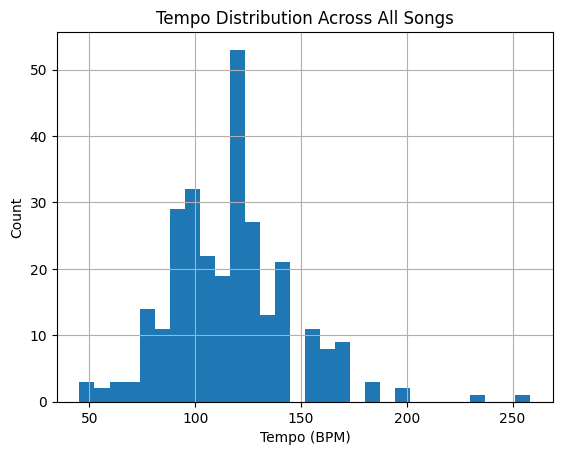

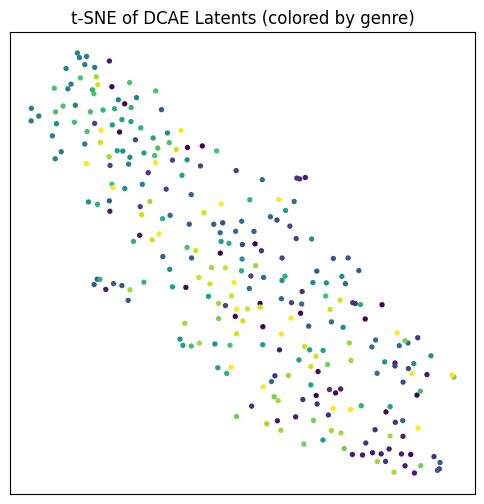

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 1) Load into a DataFrame
with open('music_vibe_data.json','r') as f:
    data = json.load(f)
df = pd.DataFrame(data)

# 2) Peek at the first few rows: filename, genre, vibe
print(df[['filename','genre','vibe_description']].head(10))

# 3) Flatten out your numeric audio features so you can summarize them:
features = pd.json_normalize(df['audio_features'])
print(features[['tempo','rms_mean','spectral_centroid_mean']].describe().round(2))

# 4) Check that every genre has exactly 20 songs:
print(df['genre'].value_counts())

# 5) Visualize the tempo distribution:
plt.figure()
features['tempo'].hist(bins=30)
plt.xlabel('Tempo (BPM)')
plt.ylabel('Count')
plt.title('Tempo Distribution Across All Songs')
plt.show()

# 6) Quick 2-D embedding of your latent space to see clustering by genre
#    (you’ll need sklearn installed; this is just for exploration)
latent_df = pd.DataFrame(df['latent'].tolist())
pca = PCA(n_components=50).fit_transform(latent_df)      # preshrink
tsne = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(pca)
plt.figure(figsize=(6,6))
plt.scatter(tsne[:,0], tsne[:,1], c=pd.factorize(df['genre'])[0], s=8)
plt.title('t-SNE of DCAE Latents (colored by genre)')
plt.xticks([]); plt.yticks([])
plt.show()


# Data Processing for training

If you haven't already, set up ACE-Step. Paste the following in the terminal:
git clone https://github.com/ace-step/ACE-Step.git

cd ACE-Step

python -m venv venv

source venv/bin/activate

pip install -e .

You can run it here: acestep --port 7865


Now that we have ACE-Step set up, we can now start to format the data appropriately.

The script below takes the files currently in GCP and uploads them to the disk. It also filters and samples, so we have a small amount of data to train the model on.

we'll be randomly selecting 5 seconds from each song to train the model on.

In [ ]:
# --- Install dependencies (run first in Colab) ---
# !pip install gcsfs datasets pandas tqdm torchaudio

import os
import json
import gcsfs
import pandas as pd
from tqdm import tqdm
from datasets import Dataset
import torchaudio
import random
import concurrent.futures

BUCKET_NAME = "uchicago-bayesian-bayes-beats"
GCS_JSON_PATH = "processed_music_vibe_data.json"
LOCAL_DATA_DIR = "/content/jamendo_data"
LOCAL_JSON_PATH = "/content/music_vibe_data.json"
HF_DATASET_PATH = "/content/my_hf_ace_dataset"

MAX_DURATION_SECONDS = 5.0
SAMPLE_SIZE = 200
SAMPLE_RATE = 48000

# --- Colab GCS Auth ---
from google.colab import auth
auth.authenticate_user()

# --- Load JSON Metadata ---
fs = gcsfs.GCSFileSystem()
with fs.open(f"{BUCKET_NAME}/{GCS_JSON_PATH}", 'rb') as f:
    data = json.load(f)
print(f"Loaded {len(data)} items from GCS JSON")

if SAMPLE_SIZE is not None:
    data = data[:SAMPLE_SIZE]

# --- Download audio files using concurrent.futures ---
def download_one_audio(gcs_path, local_data_dir=LOCAL_DATA_DIR):
    # Remove bucket prefix if present
    local_gcs_path = gcs_path
    if gcs_path.startswith(BUCKET_NAME + "/"):
        local_gcs_path = gcs_path[len(BUCKET_NAME) + 1:]
    local_path = os.path.join(local_data_dir, local_gcs_path)
    local_dir = os.path.dirname(local_path)
    os.makedirs(local_dir, exist_ok=True)
    if not os.path.exists(local_path):
        try:
            with fs.open(f"{BUCKET_NAME}/{local_gcs_path}", 'rb') as fsrc:
                with open(local_path, 'wb') as fdst:
                    fdst.write(fsrc.read())
        except Exception as e:
            print(f"❌ Failed to download {gcs_path}: {e}")
            return None
    return local_path

def download_audio_files_parallel(data, audio_col='filename', local_data_dir=LOCAL_DATA_DIR, max_workers=16):
    gcs_audio_paths = list(set(d[audio_col] for d in data))
    local_audio_paths = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(
            executor.map(lambda path: download_one_audio(path, local_data_dir), gcs_audio_paths),
            total=len(gcs_audio_paths), desc="Downloading audio (parallel)"
        ))
    local_audio_paths = [r for r in results if r is not None]
    print(f"✅ Downloaded {len(local_audio_paths)} audio files.")
    return local_audio_paths

local_audio_paths = download_audio_files_parallel(data, max_workers=16)

# --- Crop audio to MAX_DURATION_SECONDS in parallel ---
def crop_one_audio(path, max_seconds=5, sample_rate=48000):
    try:
        audio, sr = torchaudio.load(path)
        max_samples = int(sample_rate * max_seconds)
        if audio.shape[-1] > max_samples:
            start = random.randint(0, audio.shape[-1] - max_samples)
            audio = audio[:, start : start + max_samples]
            torchaudio.save(path, audio, sr)
        elif audio.shape[-1] < max_samples:
            audio = torch.nn.functional.pad(audio, (0, max_samples - audio.shape[-1]), 'constant', 0)
            torchaudio.save(path, audio, sr)
        return True
    except Exception as e:
        print(f"❌ Error processing {path}: {e}")
        return False

def crop_one_audio_star(args):
    return crop_one_audio(*args)

def crop_audio_to_duration_parallel(audio_paths, max_seconds=5, sample_rate=48000, max_workers=16):
    args = [(path, max_seconds, sample_rate) for path in audio_paths]
    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        list(tqdm(
            executor.map(crop_one_audio_star, args),
            total=len(audio_paths), desc=f"Cropping audio to {max_seconds}s (parallel)"
        ))
    print("✅ Cropping complete.")


crop_audio_to_duration_parallel(local_audio_paths, MAX_DURATION_SECONDS, SAMPLE_RATE, max_workers=16)

# --- Check durations after cropping (debug) ---
durations = []
for path in local_audio_paths:
    try:
        info = torchaudio.info(path)
        duration = info.num_frames / info.sample_rate
        durations.append(duration)
        if duration > MAX_DURATION_SECONDS + 0.5:
            print(f"❗ Warning: {path} still longer than {MAX_DURATION_SECONDS}s ({duration}s)")
    except Exception as e:
        print(f"❌ Error reading duration for {path}: {e}")

if durations:
    print(f"After cropping: Min: {min(durations):.2f}, Max: {max(durations):.2f}, Mean: {sum(durations)/len(durations):.2f}")
else:
    print("❌ No durations found after cropping!")

# --- Filter + Reformat JSON to ACE format ---
def get_duration(path):
    try:
        info = torchaudio.info(path)
        return info.num_frames / info.sample_rate
    except Exception:
        return None

recs = []
kept = 0
for i, row in enumerate(tqdm(data, desc="Filtering + formatting")):
    gcs_audio_path = row["filename"]
    if gcs_audio_path.startswith(BUCKET_NAME + "/"):
        gcs_audio_path = gcs_audio_path[len(BUCKET_NAME)+1:]
    local_audio_path = os.path.join(LOCAL_DATA_DIR, gcs_audio_path)
    duration = get_duration(local_audio_path)
    if duration is None:
        print(f"❌ Skipping {local_audio_path} (duration=None)")
        continue
    if (MAX_DURATION_SECONDS is not None) and (duration > MAX_DURATION_SECONDS + 0.5):
        print(f"❌ Skipping {local_audio_path} (too long: {duration}s)")
        continue
    recs.append({
        "filename": local_audio_path,
        "keys": os.path.splitext(os.path.basename(gcs_audio_path))[0],
        "tags": [row["genre"]],
        "norm_lyrics": "",
        "recaption": {},
        "speaker_emb_path": None
    })
    kept += 1
    if SAMPLE_SIZE and kept >= SAMPLE_SIZE:
        break

if recs:
    print(f"Sample reformatted entry:\n{json.dumps(recs[0], indent=2)}")
else:
    print("❌ No valid records!")
print(f"Final dataset size: {len(recs)}")

# --- Save as Hugging Face dataset ---
if recs:
    df = pd.DataFrame(recs)
    hf_ds = Dataset.from_pandas(df)
    hf_ds.save_to_disk(HF_DATASET_PATH)
    print("✅ Saved HuggingFace dataset to", HF_DATASET_PATH)
else:
    print("❌ No records to save!")

Loaded 287 items from GCS JSON


✅ Downloaded 200 audio files.



Cropping audio to 5.0s (parallel): 100%|██████████| 200/200 [00:16<00:00, 12.15it/s]


✅ Cropping complete.
After cropping: Min: 5.44, Max: 5.44, Mean: 5.44


Filtering + formatting: 100%|█████████▉| 199/200 [00:02<00:00, 94.90it/s]

Sample reformatted entry:
{
  "filename": "/content/jamendo_data/jamendo_by_genre/jazz/18_AdHoc_No_border.mp3",
  "keys": "18_AdHoc_No_border",
  "tags": [
    "jazz"
  ],
  "norm_lyrics": "",
  "recaption": {},
  "speaker_emb_path": null
}
Final dataset size: 200


Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

✅ Saved HuggingFace dataset to /content/my_hf_ace_dataset


In [ ]:
# we need to run more code to extact the _prompt.txt and _lyrics.txt files for each MP3 to be able to run the LORA training script.
#!pip install joblib

In [ ]:
import os
import json
from joblib import Parallel, delayed
from tqdm import tqdm

# Load your metadata
with open('/content/music_vibe_data.json', 'r') as f:
    data = json.load(f)
# Build fast lookup: <basename> -> genre/tag
genre_by_basename = {os.path.basename(d['filename']): d['genre'] for d in data}

def create_prompt_and_lyrics(mp3_path, genre_lookup):
    stem = mp3_path[:-4]
    prompt_path = stem + '_prompt.txt'
    lyrics_path = stem + '_lyrics.txt'
    basename = os.path.basename(mp3_path)
    genre = genre_lookup.get(basename, "music")
    # Write prompt (genre as string)
    with open(prompt_path, "w") as pf:
        pf.write(genre)
    # Write empty lyrics
    with open(lyrics_path, "w") as lf:
        lf.write("")
    return (prompt_path, lyrics_path)

# Find all mp3s under jamendo_data/jamendo_by_genre/*
mp3_files = []
for root, dirs, files in os.walk('/content/jamendo_data/jamendo_by_genre'):
    for file in files:
        if file.endswith('.mp3'):
            mp3_files.append(os.path.join(root, file))

# Parallel file creation (uses all available CPUs)
print(f"Creating prompt and lyrics files for {len(mp3_files)} mp3s...")
results = Parallel(n_jobs=-1)(
    delayed(create_prompt_and_lyrics)(mp3_path, genre_by_basename)
    for mp3_path in tqdm(mp3_files)
)
print("✅ All prompt and lyrics files created!")

# Sanity check on first few
print("Example output files:")
for i in range(min(3, len(results))):
    print("Prompt file:", results[i][0])
    print("Lyrics file:", results[i][1])
    with open(results[i][0]) as pf:
        print("Prompt contents:", pf.read())
    with open(results[i][1]) as lf:
        print("Lyrics contents:", repr(lf.read()))

Creating prompt and lyrics files for 200 mp3s...


100%|██████████| 200/200 [00:00<00:00, 567.02it/s]

✅ All prompt and lyrics files created!
Example output files:
Prompt file: /content/jamendo_data/jamendo_by_genre/relaxation/12_Kenny_Leonore_Midnight_Mystique_of_Mont_Choisy_prompt.txt
Lyrics file: /content/jamendo_data/jamendo_by_genre/relaxation/12_Kenny_Leonore_Midnight_Mystique_of_Mont_Choisy_lyrics.txt
Prompt contents: relaxation
Lyrics contents: ''
Prompt file: /content/jamendo_data/jamendo_by_genre/relaxation/13_PeryCreep_Lofi_for_relax_prompt.txt
Lyrics file: /content/jamendo_data/jamendo_by_genre/relaxation/13_PeryCreep_Lofi_for_relax_lyrics.txt
Prompt contents: relaxation
Lyrics contents: ''
Prompt file: /content/jamendo_data/jamendo_by_genre/relaxation/14_Kenny_Leonore_Chuchotements_parmi_les_Canna_Indica_prompt.txt
Lyrics file: /content/jamendo_data/jamendo_by_genre/relaxation/14_Kenny_Leonore_Chuchotements_parmi_les_Canna_Indica_lyrics.txt
Prompt contents: relaxation
Lyrics contents: ''


Now we have everything formatted the way ACE step expects for training.

Since the MP3s are in subfolders, change line 9 of ACE-Step/convert2hf_dataset.py to "for song_path in data_path.glob("**/*.mp3"):" --> lets us look at subdirectories.

Run the cell below for further conversion/ingestion into the data pipeline.

In [ ]:
%cd /content/ACE-Step
!python convert2hf_dataset.py --data_dir "/content/jamendo_data/jamendo_by_genre" --repeat_count 1 --output_name "/content/my_hf_ace_dataset"

/content/ACE-Step
Saving the dataset (1/1 shards): 100% 200/200 [00:00<00:00, 51861.56 examples/s]


In [ ]:
import torchaudio

durations = []
for mp3_path in mp3_files:
    try:
        info = torchaudio.info(mp3_path)
        durations.append(info.num_frames / info.sample_rate)
    except Exception as e:
        print(f"Failed to check {mp3_path}: {e}")

print("Min duration:", min(durations))
print("Max duration:", max(durations))
print("Avg duration:", sum(durations) / len(durations))


Min duration: 5.442176870748299
Max duration: 5.442176870748299
Avg duration: 5.4421768707483045


In [ ]:
# sanity check here:
from datasets import load_from_disk
ds = load_from_disk("/content/my_hf_ace_dataset")
print(ds)
print(ds[0])

Dataset({
    features: ['keys', 'filename', 'tags', 'speaker_emb_path', 'norm_lyrics', 'recaption'],
    num_rows: 200
})
{'keys': '12_Kenny_Leonore_Midnight_Mystique_of_Mont_Choisy', 'filename': '/content/jamendo_data/jamendo_by_genre/relaxation/12_Kenny_Leonore_Midnight_Mystique_of_Mont_Choisy.mp3', 'tags': ['relaxation'], 'speaker_emb_path': '', 'norm_lyrics': '', 'recaption': {}}


#TRAINING

Now that we have our data formatted, we're ready to train. The problem with this is our model is huge, and we're running out of VRAM. Before we atempt to fine-tune, we need to do a couple of things.

Before running the cells below, make sure to restart the runtime if on Google Colab.


In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
MAX_LYRIC_LENGTH = 1024      # Or what your model expects (adjust if needed)
MAX_AUDIO_LENGTH = 24 * 10 * 48000  # 240 seconds at 48kHz; adjust to your needs
MAX_CHUNK_MASK_LENGTH = 512  # Example for chunk_masks etc., set as appropriate
MAX_CLAP_ATTENTION_LENGTH = 512  # Example for clap_attention_masks, adjust if needed
MAX_CLAP_CONDITION_LENGTH = 1024 # Adjust if needed, for time dim in clap_conditions


import torch
!nvidia-smi # make sure your cache is super clean!

Sun May 25 20:33:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             51W /  400W |   14291MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# !pip install bitsandbytes
# !pip install nnaudio
import bitsandbytes as bnb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00


In [ ]:
torch.cuda.empty_cache()

In [ ]:
#!fuser -k /dev/nvidia*

In [ ]:
!python /content/ACE-Step/trainer.py \
  --dataset_path "/content/my_hf_ace_dataset" \
  --exp_name "ace_lora_finetune" \
  --logger_dir "/content/exps/logs/" \
  --checkpoint_dir "/content/exps/checkpoints/" \
  --learning_rate 1e-4 \
  --num_workers 2 \
  --accumulate_grad_batches 8 \
  --devices 1 \
  --precision 16 \
  --max_steps 5000 \
  --every_plot_step 1000000 \
  --every_n_train_steps 500 \
  --lora_config_path "/content/ACE-Step/config/zh_rap_lora_config.json"

Streaming output truncated to the last 5000 lines.
  output['candidate_lyric_chunks']: list of length 1
  output['cfg_mask_text']: torch.Size([1]) dtype=torch.int64
  output['cfg_mask_speaker']: torch.Size([1]) dtype=torch.int64
  output['cfg_mask_lyrics']: torch.Size([1]) dtype=torch.int64
transformer_output.sample.requires_grad: True
After transformer → model_pred.requires_grad = True  grad_fn = <CloneBackward0 object at 0x7c7f6b00ab60>
Final loss → requires_grad = True  grad_fn = <MeanBackward0 object at 0x7c7f6b00ab60>

[collate_fn] Processing key: keys | Batch len: 1

[collate_fn] Processing key: target_wavs | Batch len: 1
  [collate_fn] -- AUDIO block for target_wavs --
    [target_wavs][0] shape: torch.Size([2, 261225]), type: <class 'torch.Tensor'>, dim: 2
  [collate_fn] Finished processing all items in target_wavs, stacking batch of 1
  [collate_fn] Final stacked tensor for target_wavs: shape torch.Size([1, 11520000])

[collate_fn] Processing key: vocal_wavs | Batch len: 1
  [

In [ ]:
import os
from google.colab import auth
from google.cloud import storage
from concurrent.futures import ThreadPoolExecutor, as_completed

auth.authenticate_user()
bucket_name = "uchicago-bayesian-bayes-beats"
local_checkpoint_dir = "/content/exps/logs/lightning_logs/2025-05-25_22-59-37ace_lora_finetune/checkpoints"
gcs_checkpoint_dir = "checkpoints/ace-lora-finetune/test_run"

client = storage.Client()
bucket = client.bucket(bucket_name)

def upload_ckpt(local_file_path, rel_path):
    blob = bucket.blob(os.path.join(gcs_checkpoint_dir, rel_path))
    print(f"Uploading {local_file_path} to gs://{bucket_name}/{gcs_checkpoint_dir}/{rel_path}")
    blob.upload_from_filename(local_file_path)
    print(f"Uploaded {local_file_path}")

# Find all .ckpt files
ckpt_files = []
for root, dirs, files in os.walk(local_checkpoint_dir):
    for file in files:
        if file.endswith(".ckpt"):
            local_file_path = os.path.join(root, file)
            rel_path = os.path.relpath(local_file_path, local_checkpoint_dir)
            ckpt_files.append((local_file_path, rel_path))

# Upload in parallel (adjust max_workers as desired; 4 is a safe default)
with ThreadPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(upload_ckpt, local_file_path, rel_path) for local_file_path, rel_path in ckpt_files]
    for future in as_completed(futures):
        future.result()  # raises error if upload failed

Uploading /content/exps/logs/lightning_logs/2025-05-25_22-27-11ace_lora_finetune/checkpoints/epoch=0-step=1.ckpt to gs://uchicago-bayesian-bayes-beats/checkpoints/ace-lora-finetune/test_run/epoch=0-step=1.ckpt


KeyboardInterrupt: 

DO THIS IN TERMINAL

In [ ]:
acestep --checkpoint_path /content/exps/logs/lightning_logs/2025-05-25_22-27-11ace_lora_finetune/checkpoints/epoch=0-step=1.ckpt --port 7865 --device_id 0 --share true --bf16 true

In [ ]:
#!/usr/bin/env python3
"""
Script to upload a model checkpoint to Google Cloud Storage bucket
"""

import os
from google.cloud import storage
from datetime import datetime

# Configuration
BUCKET_NAME = "uchicago-bayesian-bayes-beats"
LOCAL_CHECKPOINT_PATH = "/content/exps/logs/lightning_logs/2025-05-25_22-59-37ace_lora_finetune/checkpoints/epoch=59-step=1500.ckpt"

def upload_checkpoint_to_gcs():
    """Upload the checkpoint file to Google Cloud Storage"""

    # Initialize the GCS client
    try:
        client = storage.Client()
        bucket = client.bucket(BUCKET_NAME)
        print(f"Successfully connected to bucket: {BUCKET_NAME}")
    except Exception as e:
        print(f"Error connecting to GCS: {e}")
        return False

    # Check if local file exists
    if not os.path.exists(LOCAL_CHECKPOINT_PATH):
        print(f"Error: Local checkpoint file not found at {LOCAL_CHECKPOINT_PATH}")
        return False

    # Get file size for progress tracking
    file_size = os.path.getsize(LOCAL_CHECKPOINT_PATH)
    print(f"File size: {file_size / (1024**2):.2f} MB")

    # Create destination path in bucket
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    destination_path = f"checkpoints/ace_lora_finetune_{timestamp}_epoch59_step1500.ckpt"

    try:
        # Create blob and upload
        blob = bucket.blob(destination_path)

        print(f"Starting upload to gs://{BUCKET_NAME}/{destination_path}")
        print("This may take several minutes for large files...")

        # Upload the file
        blob.upload_from_filename(LOCAL_CHECKPOINT_PATH)

        print(f"✅ Successfully uploaded checkpoint!")
        print(f"GCS Path: gs://{BUCKET_NAME}/{destination_path}")
        print(f"File URL: https://storage.googleapis.com/{BUCKET_NAME}/{destination_path}")

        return True

    except Exception as e:
        print(f"❌ Error during upload: {e}")
        return False

def main():
    print("🚀 Starting checkpoint upload to Google Cloud Storage...")
    print(f"Local file: {LOCAL_CHECKPOINT_PATH}")
    print(f"Destination bucket: {BUCKET_NAME}")
    print("-" * 60)

    success = upload_checkpoint_to_gcs()

    if success:
        print("\n🎉 Upload completed successfully!")
    else:
        print("\n💥 Upload failed. Please check the error messages above.")

if __name__ == "__main__":
    main()

🚀 Starting checkpoint upload to Google Cloud Storage...
Local file: /content/exps/logs/lightning_logs/2025-05-25_22-59-37ace_lora_finetune/checkpoints/epoch=59-step=1500.ckpt
Destination bucket: uchicago-bayesian-bayes-beats
------------------------------------------------------------
Successfully connected to bucket: uchicago-bayesian-bayes-beats
File size: 16429.38 MB
Starting upload to gs://uchicago-bayesian-bayes-beats/checkpoints/ace_lora_finetune_20250526_021904_epoch59_step1500.ckpt
This may take several minutes for large files...
✅ Successfully uploaded checkpoint!
GCS Path: gs://uchicago-bayesian-bayes-beats/checkpoints/ace_lora_finetune_20250526_021904_epoch59_step1500.ckpt
File URL: https://storage.googleapis.com/uchicago-bayesian-bayes-beats/checkpoints/ace_lora_finetune_20250526_021904_epoch59_step1500.ckpt

🎉 Upload completed successfully!
🚀 Starting checkpoint upload to Google Cloud Storage...
Local file: /content/exps/logs/lightning_logs/2025-05-25_22-59-37ace_lora_fine

In [ ]:
acestep --checkpoint_path /content/exps/logs/lightning_logs/2025-05-25_22-59-37ace_lora_finetune/checkpoints/epoch=59-step=1500.ckpt --port 7865 --device_id 0 --share true --bf16 true

In [ ]:
#!/usr/bin/env python3
"""
Script to upload entire experiment folder to Google Cloud Storage bucket
"""

import os
from google.cloud import storage
from datetime import datetime
import glob
from pathlib import Path

# Configuration
BUCKET_NAME = "uchicago-bayesian-bayes-beats"
LOCAL_EXPERIMENT_PATH = "/content/exps/logs/lightning_logs/2025-05-25_22-59-37ace_lora_finetune"

def get_all_files(directory):
    """Recursively get all files in directory"""
    files = []
    for root, dirs, filenames in os.walk(directory):
        for filename in filenames:
            file_path = os.path.join(root, filename)
            files.append(file_path)
    return files

def upload_folder_to_gcs():
    """Upload the entire experiment folder to Google Cloud Storage"""

    # Initialize the GCS client
    try:
        client = storage.Client()
        bucket = client.bucket(BUCKET_NAME)
        print(f"✅ Successfully connected to bucket: {BUCKET_NAME}")
    except Exception as e:
        print(f"❌ Error connecting to GCS: {e}")
        return False

    # Check if local folder exists
    if not os.path.exists(LOCAL_EXPERIMENT_PATH):
        print(f"❌ Error: Local experiment folder not found at {LOCAL_EXPERIMENT_PATH}")
        return False

    # Get all files in the experiment folder
    print(f"📁 Scanning folder: {LOCAL_EXPERIMENT_PATH}")
    all_files = get_all_files(LOCAL_EXPERIMENT_PATH)

    if not all_files:
        print("❌ No files found in the experiment folder")
        return False

    print(f"📊 Found {len(all_files)} files to upload")

    # Calculate total size
    total_size = sum(os.path.getsize(f) for f in all_files if os.path.exists(f))
    print(f"📦 Total size: {total_size / (1024**3):.2f} GB")

    # Create destination prefix in bucket
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    destination_prefix = f"experiments/ace_lora_finetune_{timestamp}"

    print(f"🚀 Starting upload to gs://{BUCKET_NAME}/{destination_prefix}/")
    print("=" * 60)

    uploaded_count = 0
    failed_count = 0

    for file_path in all_files:
        try:
            # Get relative path from the experiment folder
            rel_path = os.path.relpath(file_path, LOCAL_EXPERIMENT_PATH)

            # Create destination path in bucket
            destination_path = f"{destination_prefix}/{rel_path}"

            # Get file size
            file_size = os.path.getsize(file_path)
            size_mb = file_size / (1024**2)

            print(f"📤 Uploading: {rel_path} ({size_mb:.1f} MB)")

            # Create blob and upload
            blob = bucket.blob(destination_path)
            blob.upload_from_filename(file_path)

            uploaded_count += 1
            print(f"✅ Uploaded: {rel_path}")

        except Exception as e:
            failed_count += 1
            print(f"❌ Failed to upload {rel_path}: {e}")
            continue

    print("=" * 60)
    print(f"📈 Upload Summary:")
    print(f"   ✅ Successfully uploaded: {uploaded_count} files")
    print(f"   ❌ Failed uploads: {failed_count} files")
    print(f"   📍 GCS Location: gs://{BUCKET_NAME}/{destination_prefix}/")

    # List key files that were uploaded
    print(f"\n📋 Key files uploaded:")
    key_patterns = ['*.ckpt', '*.yaml', '*.json', '*.log', '*.txt']
    for pattern in key_patterns:
        matching_files = [f for f in all_files if any(f.endswith(ext) for ext in pattern.replace('*', '').split())]
        if matching_files:
            for file_path in matching_files[:5]:  # Show first 5 matches
                rel_path = os.path.relpath(file_path, LOCAL_EXPERIMENT_PATH)
                print(f"   • {rel_path}")
            if len(matching_files) > 5:
                print(f"   ... and {len(matching_files) - 5} more")

    return uploaded_count > 0

def main():
    print("🚀 Starting full experiment folder upload to Google Cloud Storage...")
    print(f"📂 Local folder: {LOCAL_EXPERIMENT_PATH}")
    print(f"🪣 Destination bucket: {BUCKET_NAME}")
    print("-" * 60)

    success = upload_folder_to_gcs()

    if success:
        print("\n🎉 Upload process completed!")
        print("💡 You can now access your experiment files from the GCS bucket")
    else:
        print("\n💥 Upload failed. Please check the error messages above.")

if __name__ == "__main__":
    main()

🚀 Starting full experiment folder upload to Google Cloud Storage...
📂 Local folder: /content/exps/logs/lightning_logs/2025-05-25_22-59-37ace_lora_finetune
🪣 Destination bucket: uchicago-bayesian-bayes-beats
------------------------------------------------------------
✅ Successfully connected to bucket: uchicago-bayesian-bayes-beats
📁 Scanning folder: /content/exps/logs/lightning_logs/2025-05-25_22-59-37ace_lora_finetune
📊 Found 32 files to upload
📦 Total size: 48.50 GB
🚀 Starting upload to gs://uchicago-bayesian-bayes-beats/experiments/ace_lora_finetune_20250526_023307/
📤 Uploading: events.out.tfevents.1748213977.eb8dd917cc36.101646.0 (0.0 MB)
✅ Uploaded: events.out.tfevents.1748213977.eb8dd917cc36.101646.0
📤 Uploading: hparams.yaml (0.0 MB)
✅ Uploaded: hparams.yaml
📤 Uploading: checkpoints/epoch=19-step=500.ckpt (16429.4 MB)
✅ Uploaded: checkpoints/epoch=19-step=500.ckpt
📤 Uploading: checkpoints/epoch=39-step=1000.ckpt (16429.4 MB)
✅ Uploaded: checkpoints/epoch=39-step=1000.ckpt
📤 Upl

In [ ]:
torch_compile = True # @param {type: "boolean"}
cpu_offload = False # @param {type: "boolean"}
overlapped_decode = True # @param {type: "boolean"}
#bf16 = True # @param {type: "boolean"}

!acestep --checkpoint_path /unzip/checkpoints/ --port 7865 --device_id 0 --share true --torch_compile {torch_compile} --cpu_offload {cpu_offload} --overlapped_decode {overlapped_decode}

In [ ]:
#!/usr/bin/env python3
"""
Script to download checkpoint files from Google Cloud Storage to local content folder
"""

import os
from google.cloud import storage
from pathlib import Path

# Configuration
BUCKET_NAME = "uchicago-bayesian-bayes-beats"
LOCAL_DOWNLOAD_PATH = "/content/checkpoints"  # Where to save in your content folder

def list_experiment_folders(bucket):
    """List all experiment folders in the bucket"""
    print("📋 Available experiment folders:")
    blobs = bucket.list_blobs(prefix="experiments/")
    folders = set()

    for blob in blobs:
        # Extract folder name from blob path
        parts = blob.name.split('/')
        if len(parts) >= 2:
            folder_name = '/'.join(parts[:2])  # experiments/folder_name
            folders.add(folder_name)

    for i, folder in enumerate(sorted(folders), 1):
        print(f"   {i}. {folder}")

    return sorted(folders)

def download_entire_folder(specific_folder="experiments/ace_lora_finetune_20250526_023307/checkpoints"):
    """Download entire checkpoint folder from Google Cloud Storage with parallel downloads"""
    import concurrent.futures
    from threading import Lock

    # Initialize the GCS client
    try:
        client = storage.Client()
        bucket = client.bucket(BUCKET_NAME)
        print(f"✅ Successfully connected to bucket: {BUCKET_NAME}")
    except Exception as e:
        print(f"❌ Error connecting to GCS: {e}")
        return False

    print(f"📂 Downloading entire folder: {specific_folder}")

    # Create local download directory
    os.makedirs(LOCAL_DOWNLOAD_PATH, exist_ok=True)

    # List ALL files in the checkpoint folder (not just .ckpt files)
    print("🔍 Scanning folder contents...")
    all_blobs = list(bucket.list_blobs(prefix=specific_folder))

    # Filter out directory markers and get actual files
    file_blobs = [blob for blob in all_blobs if not blob.name.endswith('/') and blob.size > 0]

    if not file_blobs:
        print(f"❌ No files found in {specific_folder}")
        return False

    # Calculate total size
    total_size = sum(blob.size for blob in file_blobs)
    total_size_gb = total_size / (1024**3)

    print(f"🎯 Found {len(file_blobs)} files to download")
    print(f"📦 Total size: {total_size_gb:.2f} GB")

    # Show file breakdown
    file_types = {}
    for blob in file_blobs:
        ext = os.path.splitext(blob.name)[1] or 'no_ext'
        file_types[ext] = file_types.get(ext, 0) + 1

    print("📊 File types:")
    for ext, count in file_types.items():
        print(f"   • {ext}: {count} files")

    print(f"\n🚀 Starting parallel download to {LOCAL_DOWNLOAD_PATH}/")
    print("🚄 Using A100 GPU's high-bandwidth for faster downloads!")
    print("=" * 60)

    # Parallel download function
    def download_file(blob):
        try:
            # Preserve folder structure
            relative_path = blob.name.replace(specific_folder, '').lstrip('/')
            local_path = os.path.join(LOCAL_DOWNLOAD_PATH, relative_path)

            # Create subdirectories if needed
            local_dir = os.path.dirname(local_path)
            if local_dir:
                os.makedirs(local_dir, exist_ok=True)

            # Download file
            blob.download_to_filename(local_path)

            # Verify download
            if os.path.exists(local_path):
                file_size_mb = os.path.getsize(local_path) / (1024**2)
                return f"✅ {relative_path} ({file_size_mb:.1f} MB)"
            else:
                return f"❌ Failed: {relative_path}"

        except Exception as e:
            return f"❌ Error downloading {blob.name}: {e}"

    # Use ThreadPoolExecutor for parallel downloads
    # A100 has high memory bandwidth, so we can handle many concurrent downloads
    downloaded_count = 0
    failed_count = 0

    with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
        # Submit all download tasks
        future_to_blob = {executor.submit(download_file, blob): blob for blob in file_blobs}

        # Process completed downloads
        for future in concurrent.futures.as_completed(future_to_blob):
            result = future.result()
            print(result)

            if result.startswith("✅"):
                downloaded_count += 1
            else:
                failed_count += 1

    print("=" * 60)
    print(f"📈 Download Summary:")
    print(f"   ✅ Successfully downloaded: {downloaded_count} files")
    print(f"   ❌ Failed downloads: {failed_count} files")
    print(f"   📍 Local location: {LOCAL_DOWNLOAD_PATH}/")

    # List all downloaded files
    if downloaded_count > 0:
        print(f"\n📋 Downloaded files:")
        for root, dirs, files in os.walk(LOCAL_DOWNLOAD_PATH):
            for file in files:
                full_path = os.path.join(root, file)
                rel_path = os.path.relpath(full_path, LOCAL_DOWNLOAD_PATH)
                size_mb = os.path.getsize(full_path) / (1024**2)
                print(f"   • {rel_path} ({size_mb:.1f} MB)")

    return downloaded_count > 0

def main():
    print("🚀 Starting FULL FOLDER download from Google Cloud Storage...")
    print(f"🪣 Source bucket: {BUCKET_NAME}")
    print(f"📂 Target folder: experiments/ace_lora_finetune_20250526_023307/checkpoints")
    print(f"📂 Download location: {LOCAL_DOWNLOAD_PATH}")
    print("💪 Leveraging A100 GPU high-bandwidth connection!")
    print("-" * 60)

    success = download_entire_folder()

    if success:
        print("\n🎉 Full folder download completed successfully!")
        print(f"💡 All checkpoint files and configs are now available in {LOCAL_DOWNLOAD_PATH}/")
        print(f"🔧 You can now use the directory with:")
        print(f"   acestep --checkpoint_path {LOCAL_DOWNLOAD_PATH}/ --port 7865")
        print("📁 This should auto-select the best checkpoint and load configs!")
    else:
        print("\n💥 Download failed. Please check the error messages above.")

if __name__ == "__main__":
    main()

🚀 Starting FULL FOLDER download from Google Cloud Storage...
🪣 Source bucket: uchicago-bayesian-bayes-beats
📂 Target folder: experiments/ace_lora_finetune_20250526_023307/checkpoints
📂 Download location: /content/checkpoints
💪 Leveraging A100 GPU high-bandwidth connection!
------------------------------------------------------------
✅ Successfully connected to bucket: uchicago-bayesian-bayes-beats
📂 Downloading entire folder: experiments/ace_lora_finetune_20250526_023307/checkpoints
🔍 Scanning folder contents...
🎯 Found 6 files to download
📦 Total size: 48.32 GB
📊 File types:
   • .ckpt: 3 files
   • .safetensors: 3 files

🚀 Starting parallel download to /content/checkpoints/
🚄 Using A100 GPU's high-bandwidth for faster downloads!
✅ epoch=19-step=500_lora/pytorch_lora_weights.safetensors (62.5 MB)
✅ epoch=39-step=1000_lora/pytorch_lora_weights.safetensors (62.5 MB)
✅ epoch=59-step=1500_lora/pytorch_lora_weights.safetensors (62.5 MB)
✅ epoch=39-step=1000.ckpt (16429.4 MB)
✅ epoch=19-ste

In [ ]:
!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:128
!export CUDA_LAUNCH_BLOCKING=0

In [ ]:
!acestep --checkpoint_path /unzip/checkpoints/ --port 7865 --device_id 0 --share true --torch_compile true --cpu_offload false --overlapped_decode true

2025-05-26 19:30:22.927490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748287822.949375   12550 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748287822.955909   12550 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
* Running on local URL:  http://127.0.0.1:7865
* Running on public URL: https://197fbfaf148b99a4b7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
2025-05-26 19:31:47.116 | WARNING  | acestep.pipeline_ace_step:__call__:1477 - Checkpoint not loaded, loading checkpo